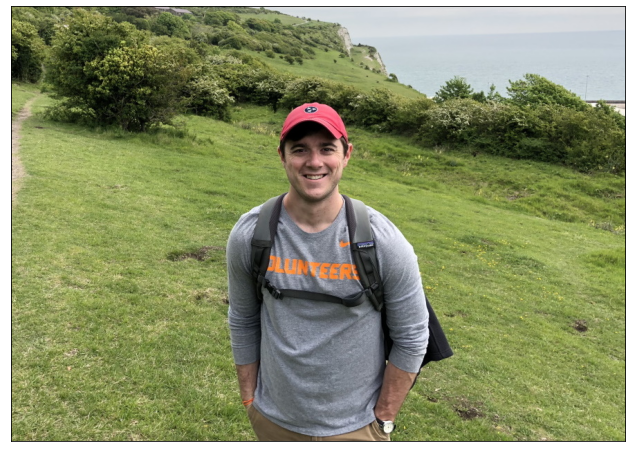

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open('Data/adam.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

In [2]:
from mask import *
import onnxruntime as rt

image_data = preprocess(image)
session = rt.InferenceSession('Data/MaskRCNN-10.onnx')
input_name = session.get_inputs()[0].name
result = session.run(None, { input_name: image_data })

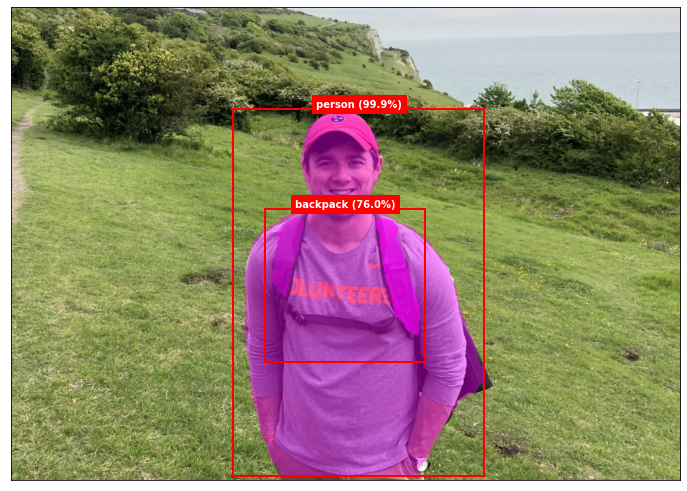

In [3]:
boxes = result[0]  # Bounding boxes
labels = result[1] # Class labels
scores = result[2] # Confidence scores
masks = result[3]  # Segmentation masks

annotate_image(image, boxes, labels, scores, masks)

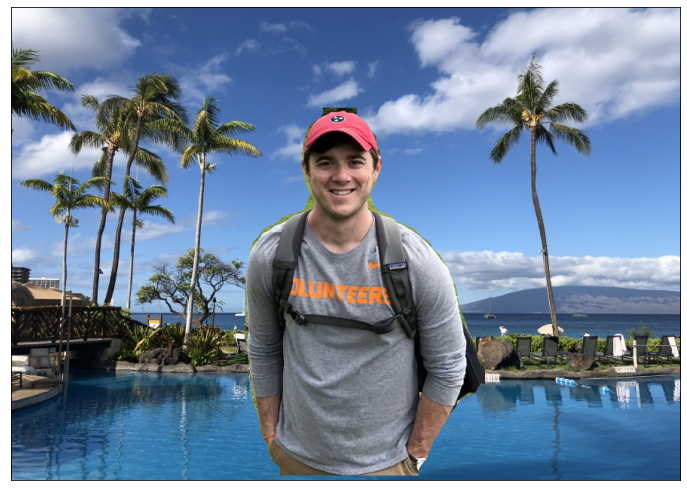

In [4]:
fg_image = Image.open('Data/adam.jpg')
bg_image = Image.open('Data/maui.jpg')

change_background(session, fg_image, bg_image)